# Tutorial: Classifiers and regularizers

---
## Objectives

In this tutorial, we'll revisit logistic regression. In the context of linear regression, we will learn about regularization, including the different approaches and the influence of hyperparameters.
<br>

We would like to acknowledge [Steinmetz _et al._, 2019](https://www.nature.com/articles/s41586-019-1787-x) for sharing their data, a subset of which is used here.

We thank NMA, most of this tutorial is inspired by NMA Materials on GLM

---
# Setup

##  Install and import feedback gadget


In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from IPython.display import IFrame
from ipywidgets import widgets

##  Figure settings


In [ ]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

##  Plotting Functions


In [6]:
# @title Plotting Functions

def plot_weights(models, sharey=True):
  """Draw a stem plot of weights for each model in models dict."""
  n = len(models)
  f = plt.figure(figsize=(10, 2.5 * n))
  axs = f.subplots(n, sharex=True, sharey=sharey)
  axs = np.atleast_1d(axs)

  for ax, (title, model) in zip(axs, models.items()):

    ax.margins(x=.02)
    stem = ax.stem(model.coef_.squeeze())
    stem[0].set_marker(".")
    stem[0].set_color(".2")
    stem[1].set_linewidths(.5)
    stem[1].set_color(".2")
    stem[2].set_visible(False)
    ax.axhline(0, color="C3", lw=3)
    ax.set(ylabel="Weight", title=title)
  ax.set(xlabel="Neuron (a.k.a. feature)")
  f.tight_layout()
  plt.show()


def plot_function(f, name, var, points=(-10, 10)):
    """Evaluate f() on linear space between points and plot.

    Args:
      f (callable): function that maps scalar -> scalar
      name (string): Function name for axis labels
      var (string): Variable name for axis labels.
      points (tuple): Args for np.linspace to create eval grid.
    """
    x = np.linspace(*points)
    ax = plt.figure().subplots()
    ax.plot(x, f(x))
    ax.set(
      xlabel=f'${var}$',
      ylabel=f'${name}({var})$'
    )
    plt.show()


def plot_model_selection(C_values, accuracies):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, accuracies, marker="o")
  best_C = C_values[np.argmax(accuracies)]
  ax.set(
      xticks=C_values,
      xlabel="C",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
  )
  plt.show()


def plot_non_zero_coefs(C_values, non_zero_l1, n_voxels):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, non_zero_l1, marker="o")
  ax.set(
    xticks=C_values,
    xlabel="C",
    ylabel="Number of non-zero coefficients",
  )
  ax.axhline(n_voxels, color=".1", linestyle=":")
  ax.annotate("Total\n# Neurons", (C_values[0], n_voxels * .98), va="top")
  plt.show()

##  Data retrieval and loading


In [7]:
#@title Data retrieval and loading
import os
import requests
import hashlib

url = "https://osf.io/r9gh8/download"
fname = "W1D4_steinmetz_data.npz"
expected_md5 = "d19716354fed0981267456b80db07ea8"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

def load_steinmetz_data(data_fname=fname):

  with np.load(data_fname) as dobj:
    data = dict(**dobj)

  return data

---

# Section 1: Logistic regression

Logistic Regression is a binary classification model. 

## Section 1.1: The logistic regression model



The fundamental input/output equation of logistic regression is:

\begin{equation}
\hat{y} = \sigma(\theta^\top x)
\end{equation}

Note that we interpret the output of logistic regression, $\hat{y}$, as the **probability that y = 1** given inputs $x$ and parameters $\theta$.


The cost function for logistic regression (which is proportional to the negative of the log likelihood) is given by:

\begin{equation}
\mathcal{C}(\mathbf{\theta}) = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
\end{equation}

where

\begin{equation}
\hat{y}_i = \sigma(\mathbf{\theta}^T \mathbf{x}_i) = \frac{1}{1 + e^{-\mathbf{\theta}^T \mathbf{x}_i}}
\end{equation}

The above loss function is also known as the binary cross entropy loss.It measures the dissimilarity between the true labels and the predicted probabilities. Note that minimizing the binary cross-entropy loss is equivalent to maximizing the log-likelihood in the context of logistic regression. 

---
# Section 2: Decoding neural data with logistic regression

## Section 2.1: Setting up the data


In this notebook we'll use the Steinmetz dataset that you have seen previously. Recall that this dataset includes recordings of neurons as mice perform a decision task.

Mice had the task of turning a wheel to indicate whether they perceived a Gabor stimulus to the left, to the right, or not at all. Neuropixel probes measured spikes across the cortex. Check out the following task schematic below from the BiorXiv preprint.




 Execute to see schematic


In [ ]:
# @markdown Execute to see schematic
import IPython
IPython.display.Image("http://kordinglab.com/images/others/steinmetz-task.png")

Today we're going to **decode the decision from neural data** using Logistic Regression. We will only consider trials where the mouse chose "Left" or "Right" and ignore NoGo trials.

### Data format

In the hidden `Data retrieval and loading` cell, there is a function that loads the data:

- `spikes`: an array of normalized spike rates with shape `(n_trials, n_neurons)`
- `choices`: a vector of 0s and 1s, indicating the animal's behavioural response, with length `n_trials`.

In [8]:
data = load_steinmetz_data()
for key, val in data.items():
  print(key, val.shape)

y = data["choices"]
X = data["spikes"]

spikes (276, 691)
choices (276,)


As with other supervised models (for instance, linear regression), we will need two data structures:

- an `X` matrix with shape `(n_samples, n_features)`
- a `y` vector with length `n_samples`.

We are going to predict behaviour (`y`) from the neural responses (`X`):

## Section 2.2: Fitting the model

Using a Logistic Regression model within `scikit-learn` is very simple.

In [9]:
# Define the model
log_reg = LogisticRegression(penalty=None)

# Fit it to data
log_reg.fit(X, y)

LogisticRegression(penalty=None)

There's two steps here:

- We *initialized* the model with a hyperparameter, telling it what penalty to use (we'll focus on this in the second part of the notebook)
- We *fit* the model by passing it the `X` and `y` objects.



## Section 2.3: Classifying the training data

Fitting the model performs maximum likelihood optimization, learning a set of *feature weights*. We can use those learned weights to *classify* new data, or predict the labels for each sample:

In [10]:
y_pred = log_reg.predict(X)

## Section 2.4: Evaluating the model

Now, we need to evaluate the predictions of the model. We will use an *accuracy* score for this purpose. The accuracy of a classifier is determined by the proportion of correct trials, where the predicted label matches the true label, out of the total number of trials.

Classifier accuracy

For the first exercise, implement a function to evaluate a classifier using the accuracy score. Use it to get the accuracy of the classifier on the *training* data.

In [11]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.
  """
  
  y_pred = model.predict(X)

  accuracy = (y == y_pred).sum() / len(y)

  return accuracy


# Compute train accuracy
train_accuracy = compute_accuracy(X, y, log_reg)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

Accuracy on the training data: 100.00%


You should see
```
Accuracy on the training data: 100.00%
```

## Section 2.5: Cross-validating the classifier


Classification accuracy on the training data is 100%! That might sound impressive, but you should recall from yesterday the concept of *overfitting*: the classifier may have learned something idiosyncratic about the training data. If that's the case, it won't have really learned the underlying data->decision function, and thus won't generalize well to new data.

To check this, we can evaluate the *cross-validated* accuracy.


 Execute to see schematic


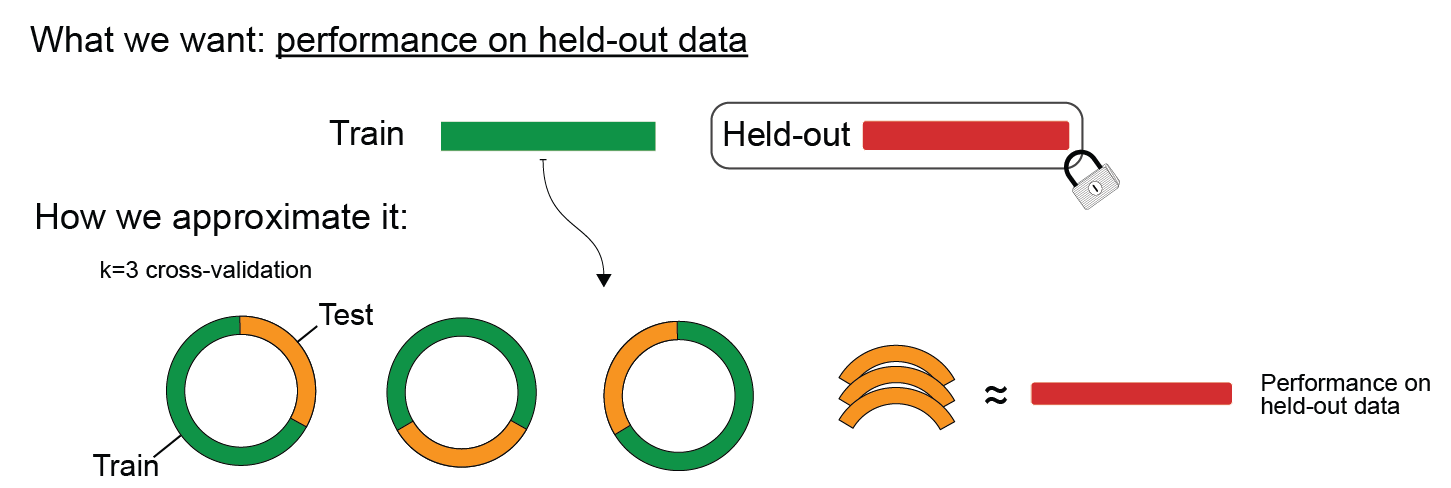

In [12]:
# @markdown Execute to see schematic
import IPython
IPython.display.Image("http://kordinglab.com/images/others/justCV-01.png")

### Cross-validating using `scikit-learn` helper functions

`scikit-learn` offers a number of [helpful functions](https://scikit-learn.org/stable/model_selection.html) that will do the cross-validation for you. For example, you can cross-validate a classifier using `cross_val_score`.

`cross_val_score` takes a `sklearn` model like `LogisticRegression`, as well as your `X` and `y` data. It then retrains your model on test/train splits of `X` and `y`, and returns the test accuracy on each of the test sets.

In [14]:
accuracies = cross_val_score(LogisticRegression(penalty=None), X, y, cv=8)  # k=8 cross validation

 Run to plot out these `k=8` accuracy scores.


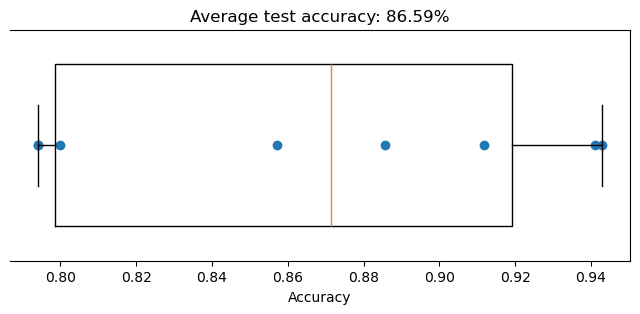

In [15]:
# @markdown Run to plot out these `k=8` accuracy scores.
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)
plt.show()

The lower cross-validated accuracy compared to the training accuracy (100%) suggests that the model is being *overfit*. Is this surprising? Think about the shape of the $X$ matrix:

In [16]:
print(X.shape)

(276, 691)


The model has almost three times as many features as samples. This is a situation where overfitting is very likely (almost guaranteed).

**Link to neuroscience**: Neuro data commonly has more features than samples. Having more neurons than independent trials is one example. In fMRI data, there are commonly more measured voxels than independent trials.


### Why more features than samples leads to overfitting

In brief, the variance of model estimation increases when there are more features than samples. That is, you would get a very different model every time you get new data and run `.fit()`. This is very related to the *bias/variance tradeoff* you learned about on day 1.

Why does this happen? Here's a tiny example to get your intuition going. Imagine trying to find a best-fit line in 2D when you only have 1 datapoint. There are simply an infinite number of lines that pass through that point. This is the situation we find ourselves in with more features than samples.

### What we can do about it
As you learned during the lectures, you can decrease model variance if you don't mind increasing its bias. Here, we will increase bias by assuming that the correct parameters are all small. In our 2D example, this is like preferring the horizontal line to all others. This is one example of *regularization*.

-----
# Section 3: Regularization


Regularization forces a model to learn a set solutions you *a priori* believe to be more correct, which reduces overfitting because it doesn't have as much flexibility to fit idiosyncracies in the training data. This adds model bias, but it's a good bias because you know (maybe) that parameters should be small or mostly 0.

In ML, a common form of regularization is to *shrink* the classifier weights. In a linear model, you can see its effect by plotting the weights. We've defined a helper function, `plot_weights`, that we'll use extensively in this section.


Here is what the weights look like for a Logistic Regression model with no regularization:

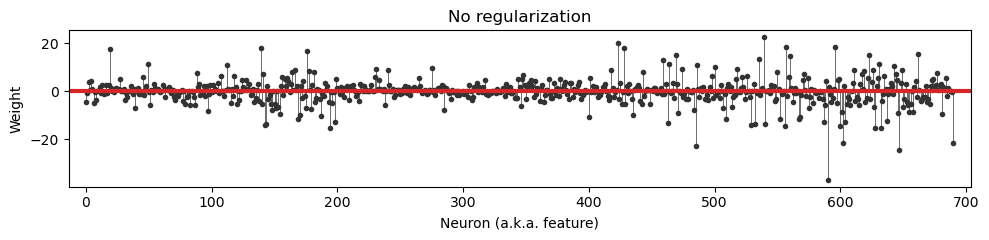

In [17]:
log_reg = LogisticRegression(penalty=None).fit(X, y)
plot_weights({"No regularization": log_reg})

It's important to understand this plot. Each dot visualizes a value in our parameter vector $\theta$. Since each feature is the time-averaged response of a neuron, each dot shows how the model uses each neuron to estimate a decision.

Note the scale of the y-axis. Some neurons have values of about $20$, whereas others scale to $-20$.

## Section 3.1: $L_2$ regularization

Regularization comes in different flavors. A very common one uses an $L_2$ or "ridge" penalty. This changes the objective function to

\begin{equation}
\mathcal{C}(\mathbf{\theta}) = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right] +\beta\sum_i\theta_i^2,
\end{equation}

where $\beta$ is a *hyperparameter* that sets the *strength* of the regularization.

You can use regularization in `scikit-learn` by changing the `penalty`, and you can set the strength of the regularization with the `C` hyperparameter ($C = \frac{1}{\beta}$, so this sets the *inverse* regularization).

Let's compare the unregularized classifier weights with the classifier weights when we use the default `C = 1`:

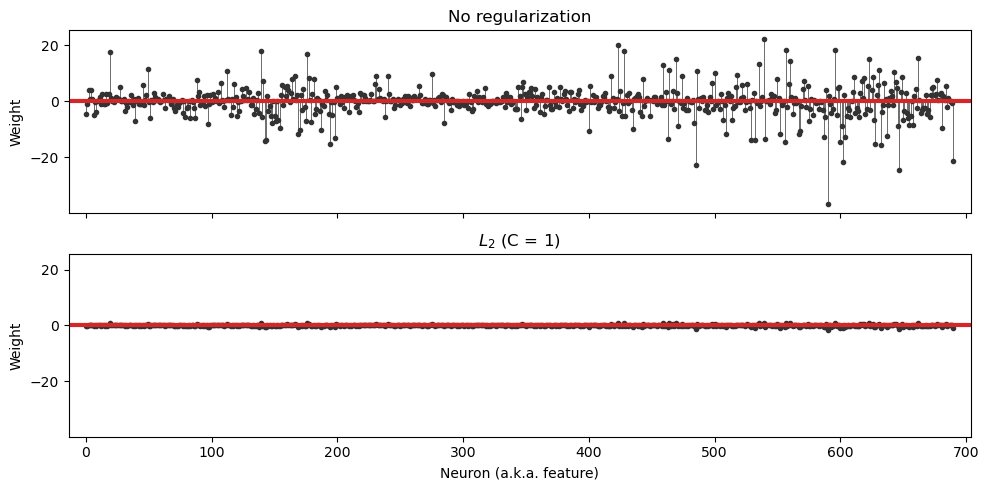

In [18]:
log_reg_l2 = LogisticRegression(penalty="l2", C=1).fit(X, y)

# now show the two models
models = {
  "No regularization": log_reg,
  "$L_2$ (C = 1)": log_reg_l2,
}
plot_weights(models)

Using the same scale for the two y axes, it's almost impossible to see the $L_2$ weights. Let's allow the y axis scales to adjust to each set of weights:

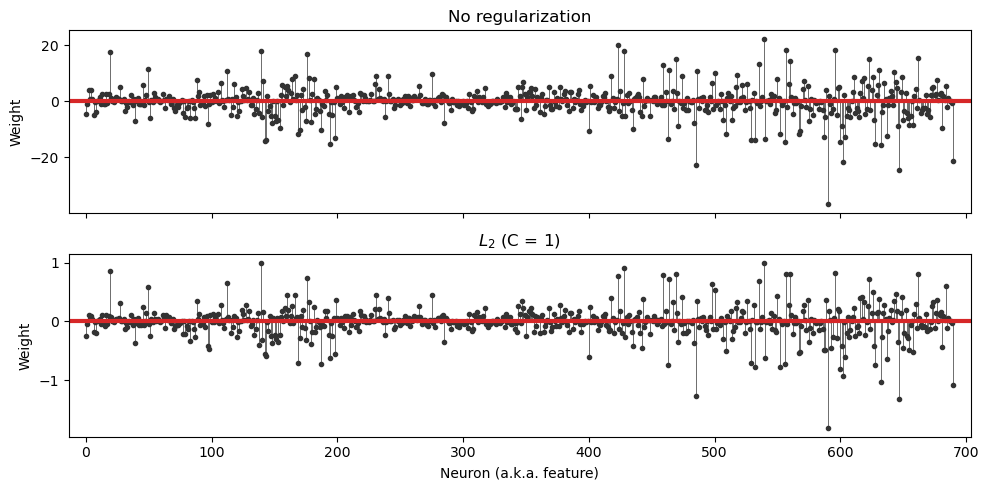

In [19]:
plot_weights(models, sharey=False)


Now you can see that the weights have the same basic pattern, but the regularized weights are an order-of-magnitude smaller.

### Interactive Demo 3.1: The effect of varying C on parameter size

We can use this same approach to see how the weights depend on the *strength* of the regularization:

 Execute this cell to enable the widget!


In [20]:
# @markdown Execute this cell to enable the widget!

# Precompute the models so the widget is responsive
log_C_steps = 1, 11, 1
penalized_models = {}
for log_C in np.arange(*log_C_steps, dtype=int):
  m = LogisticRegression("l2", C=10 ** log_C, max_iter=5000)
  penalized_models[log_C] = m.fit(X, y)

@widgets.interact
def plot_observed(log_C = widgets.IntSlider(value=1, min=1, max=10, step=1)):
  models = {
    "No regularization": log_reg,
    f"$L_2$ (C = $10^{{{log_C}}}$)": penalized_models[log_C]
  }
  plot_weights(models)

interactive(children=(IntSlider(value=1, description='log_C', max=10, min=1), Output()), _dom_classes=('widget…

Recall from above that $C=\frac1\beta$ so larger $C$ is less regularization. The top panel corresponds to $C \rightarrow \infty$.

## Section 3.2: $L_1$ regularization


$L_2$ is not the only option for regularization. There is also the $L_1$, or "Lasso" penalty. This changes the objective function to

\begin{equation}
\mathcal{C}(\mathbf{\theta}) = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right] +\beta\sum_i|\theta_i|
\end{equation}

In practice, using the summed absolute values of the weights causes *sparsity*: instead of just getting smaller, some of the weights will get forced to $0$:

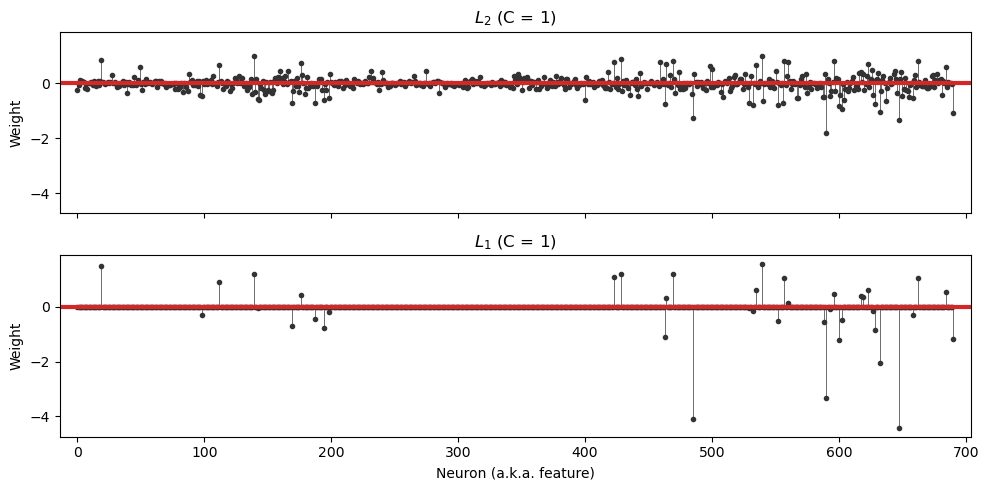

In [21]:
log_reg_l1 = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
log_reg_l1.fit(X, y)
models = {
  "$L_2$ (C = 1)": log_reg_l2,
  "$L_1$ (C = 1)": log_reg_l1,
}
plot_weights(models)

Note: You'll notice that we added two additional parameters: `solver="saga"` and `max_iter=5000`. The `LogisticRegression` class can use several different optimization algorithms ("solvers"), and not all of them support the $L_1$ penalty. At a certain point, the solver will give up if it hasn't found a minimum value. The `max_iter` parameter tells it to make more attempts; otherwise, we'd see an ugly warning about "convergence".

## Section 3.3: The key difference between $L_1$ and $L_2$ regularization: sparsity


When should you use $L_1$ vs. $L_2$ regularization? Both penalties shrink parameters, and both will help reduce overfitting. However, the models they lead to are different.

In particular, the $L_1$ penalty encourages *sparse* solutions in which most parameters are 0. Let's unpack the notion of sparsity.

A "dense" vector has mostly nonzero elements:
$\begin{bmatrix}
  0.1 \\ -0.6\\-9.1\\0.07
\end{bmatrix}$.
A "sparse" vector has mostly zero elements:
$\begin{bmatrix}
  0 \\ -0.7\\ 0\\0
\end{bmatrix}$.

The same is true of matrices:

 Execute to plot a dense and a sparse matrix


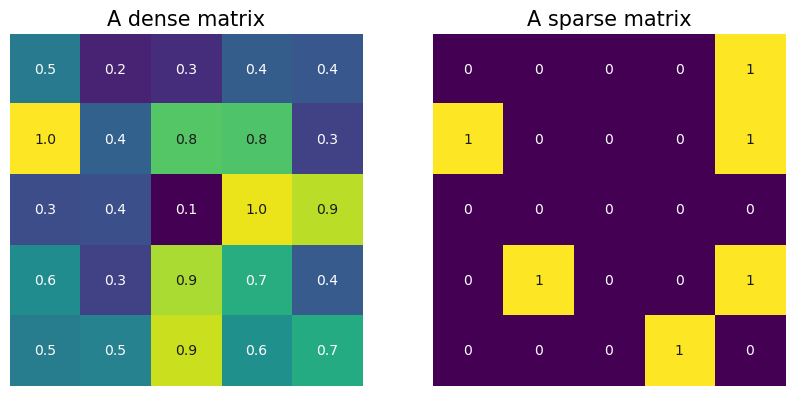

In [22]:
# @markdown Execute to plot a dense and a sparse matrix
np.random.seed(50)
n = 5
M = np.random.random((n, n))
M_sparse = np.random.choice([0, 1], size=(n, n), p=[0.8, 0.2])

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

axs[0].imshow(M)
axs[1].imshow(M_sparse)
axs[0].axis('off')
axs[1].axis('off')
axs[0].set_title("A dense matrix", fontsize=15)
axs[1].set_title("A sparse matrix", fontsize=15)
text_kws = dict(ha="center", va="center")
for i in range(n):
  for j in range(n):
    iter_parts = axs, [M, M_sparse], ["{:.1f}", "{:d}"]
    for ax, mat, fmt in zip(*iter_parts):
      val = mat[i, j]
      color = ".1" if val > .7 else "w"
      ax.text(j, i, fmt.format(val), c=color, **text_kws)
plt.show()

### The effect of $L_1$ regularization on parameter sparsity

Please complete the following function to fit a regularized `LogisticRegression` model and return **the number of coefficients in the parameter vector that are equal to 0**.

Don't forget to check out the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).


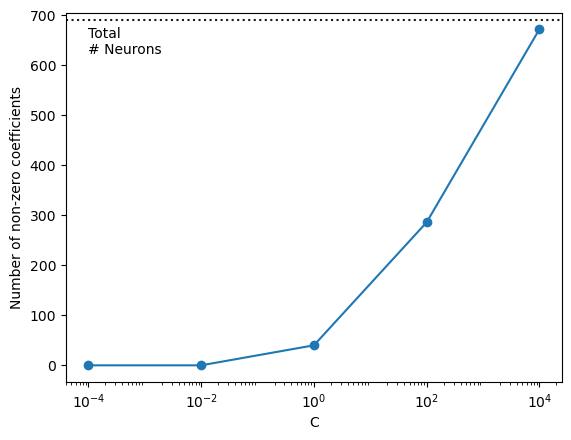

In [23]:
def count_non_zero_coefs(X, y, C_values):
  """Fit models with different L1 penalty values and count non-zero coefficients.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): List of hyperparameter values

  Returns:
    non_zero_coefs (list): number of coefficients in each model that are nonzero

  """
  
  non_zero_coefs = []
  for C in C_values:

    # Initialize and fit the model
    # (Hint, you may need to set max_iter)
    model = LogisticRegression(penalty="l1", C=C, solver="saga", max_iter=5000)
    model.fit(X,y)

    # Get the coefs of the fit model (in sklearn, we can do this using model.coef_)
    coefs = model.coef_

    # Count the number of non-zero elements in coefs
    non_zero = np.sum(coefs != 0)
    non_zero_coefs.append(non_zero)

  return non_zero_coefs


# Use log-spaced values for C
C_values = np.logspace(-4, 4, 5)

# Count non zero coefficients
non_zero_l1 = count_non_zero_coefs(X, y, C_values)

# Visualize
plot_non_zero_coefs(C_values, non_zero_l1, n_voxels=X.shape[1])

Smaller $C$ (bigger $\beta$) leads to sparser solutions.

**Link to neuroscience**: When is it OK to assume that the parameter vector is sparse? Whenever it is true that most features don't affect the outcome. One use-case might be decoding low-level visual features from whole-brain fMRI: we may expect only voxels in V1 and thalamus should be used in the prediction.

**WARNING**: be careful when interpreting $\theta$. Never interpret the nonzero coefficients as *evidence* that only those voxels/neurons/features carry information about the outcome. This is a product of our regularization scheme, and thus *our prior assumption that the solution is sparse*. Other regularization types or models may find very distributed relationships across the brain. Never use a model as evidence for a phenomena when that phenomena is encoded in the assumptions of the model.

## Section 3.4: Choosing the regularization penalty


In the examples above, we just picked arbitrary numbers for the strength of regularization. How do you know what value of the hyperparameter to use?

The answer is the same as when you want to know whether you have learned good parameter values: use cross-validation. The best hyperparameter will be the one that allows the model to generalize best to unseen data.

### Model selection

In the final exercise, we will use cross-validation to evaluate a set of models, each with a different $L_2$ penalty. Your `model_selection` function should have a for-loop that gets the mean cross-validated accuracy for each penalty value (use the `cross_val_score` function that we introduced above, with 8 folds).

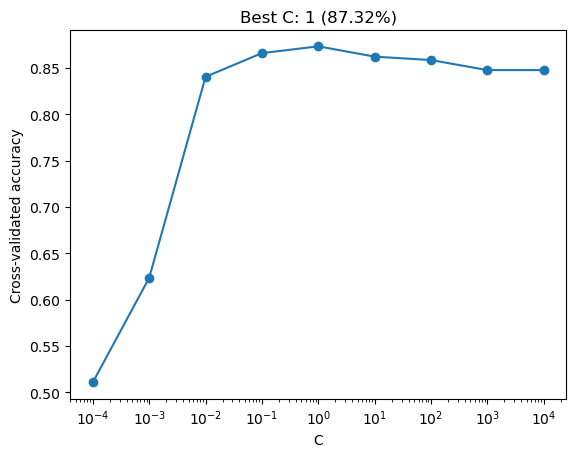

In [24]:
def model_selection(X, y, C_values):
  """Compute CV accuracy for each C value.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): Array of hyperparameter values

  Returns:
    accuracies (1D array): CV accuracy with each value of C

  """
 
  accuracies = []
  for C in C_values:

    # Initialize and fit the model
    # (Hint, you may need to set max_iter)
    model = LogisticRegression(penalty="l2", C=C, max_iter=5000)

    # Get the accuracy for each test split using cross-validation
    accs = cross_val_score(model, X, y, cv=8)

    # Store the average test accuracy for this value of C
    accuracies.append(accs.mean())

  return accuracies


# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

# Compute accuracies
accuracies = model_selection(X, y, C_values)

# Visualize
plot_model_selection(C_values, accuracies)

This plot suggests that the right value of $C$ does matter — up to a point. Remember that C is the *inverse* regularization. The plot shows that models where the regularization was too strong (small C values) performed very poorly. For $C > 10^{-2}$, the differences are marginal, but the best performance was obtained with an intermediate value ($C \approx 10^1$).

---
# Summary


In this notebook, we applied logistic regression to a *neural decoding* problem: we tried to predict an animal's behavioural choice from its neural activity. We saw again how important it is to use *cross-validation* to evaluate complex models that are at risk for *overfitting*, and we learned how *regularization* can be used to fit models that generalize better. Finally, we learned about some of the different options for regularization, and we saw how cross-validation can be useful for *model selection*.

---
# Notation

\begin{align}
x &\quad \text{input}\\
y &\quad \text{measurement, response}\\
\theta &\quad \text{parameter}\\
\sigma(z) &\quad \text{logistic function}\\
C &\quad \text{inverse regularization strength parameter}\\
\beta &\quad \text{regularization strength parameter}\\
\hat{y} &\quad \text{estimated output}\\
L_1 &\quad \text{Lasso regularization}\\
L_2 &\quad \text{ridge regularization}\\
\end{align}

---
# Extras


## Bonus Section: More detail about model selection

In the final exercise, we used all of the data to choose the hyperparameters. That means we don't have any fresh data left over to evaluate the performance of the selected model. In practice, you would want to have two *nested* layers of cross-validation, where the final evaluation is performed on data that played no role in selecting or training the model.

Indeed, the proper method for splitting your data to choose hyperparameters can get confusing. Here's a guide that the authors of this notebook developed while writing a tutorial on using machine learning for neural decoding [arxiv:1708.00909](https://arxiv.org/abs/1708.00909).

 Execute to see schematic


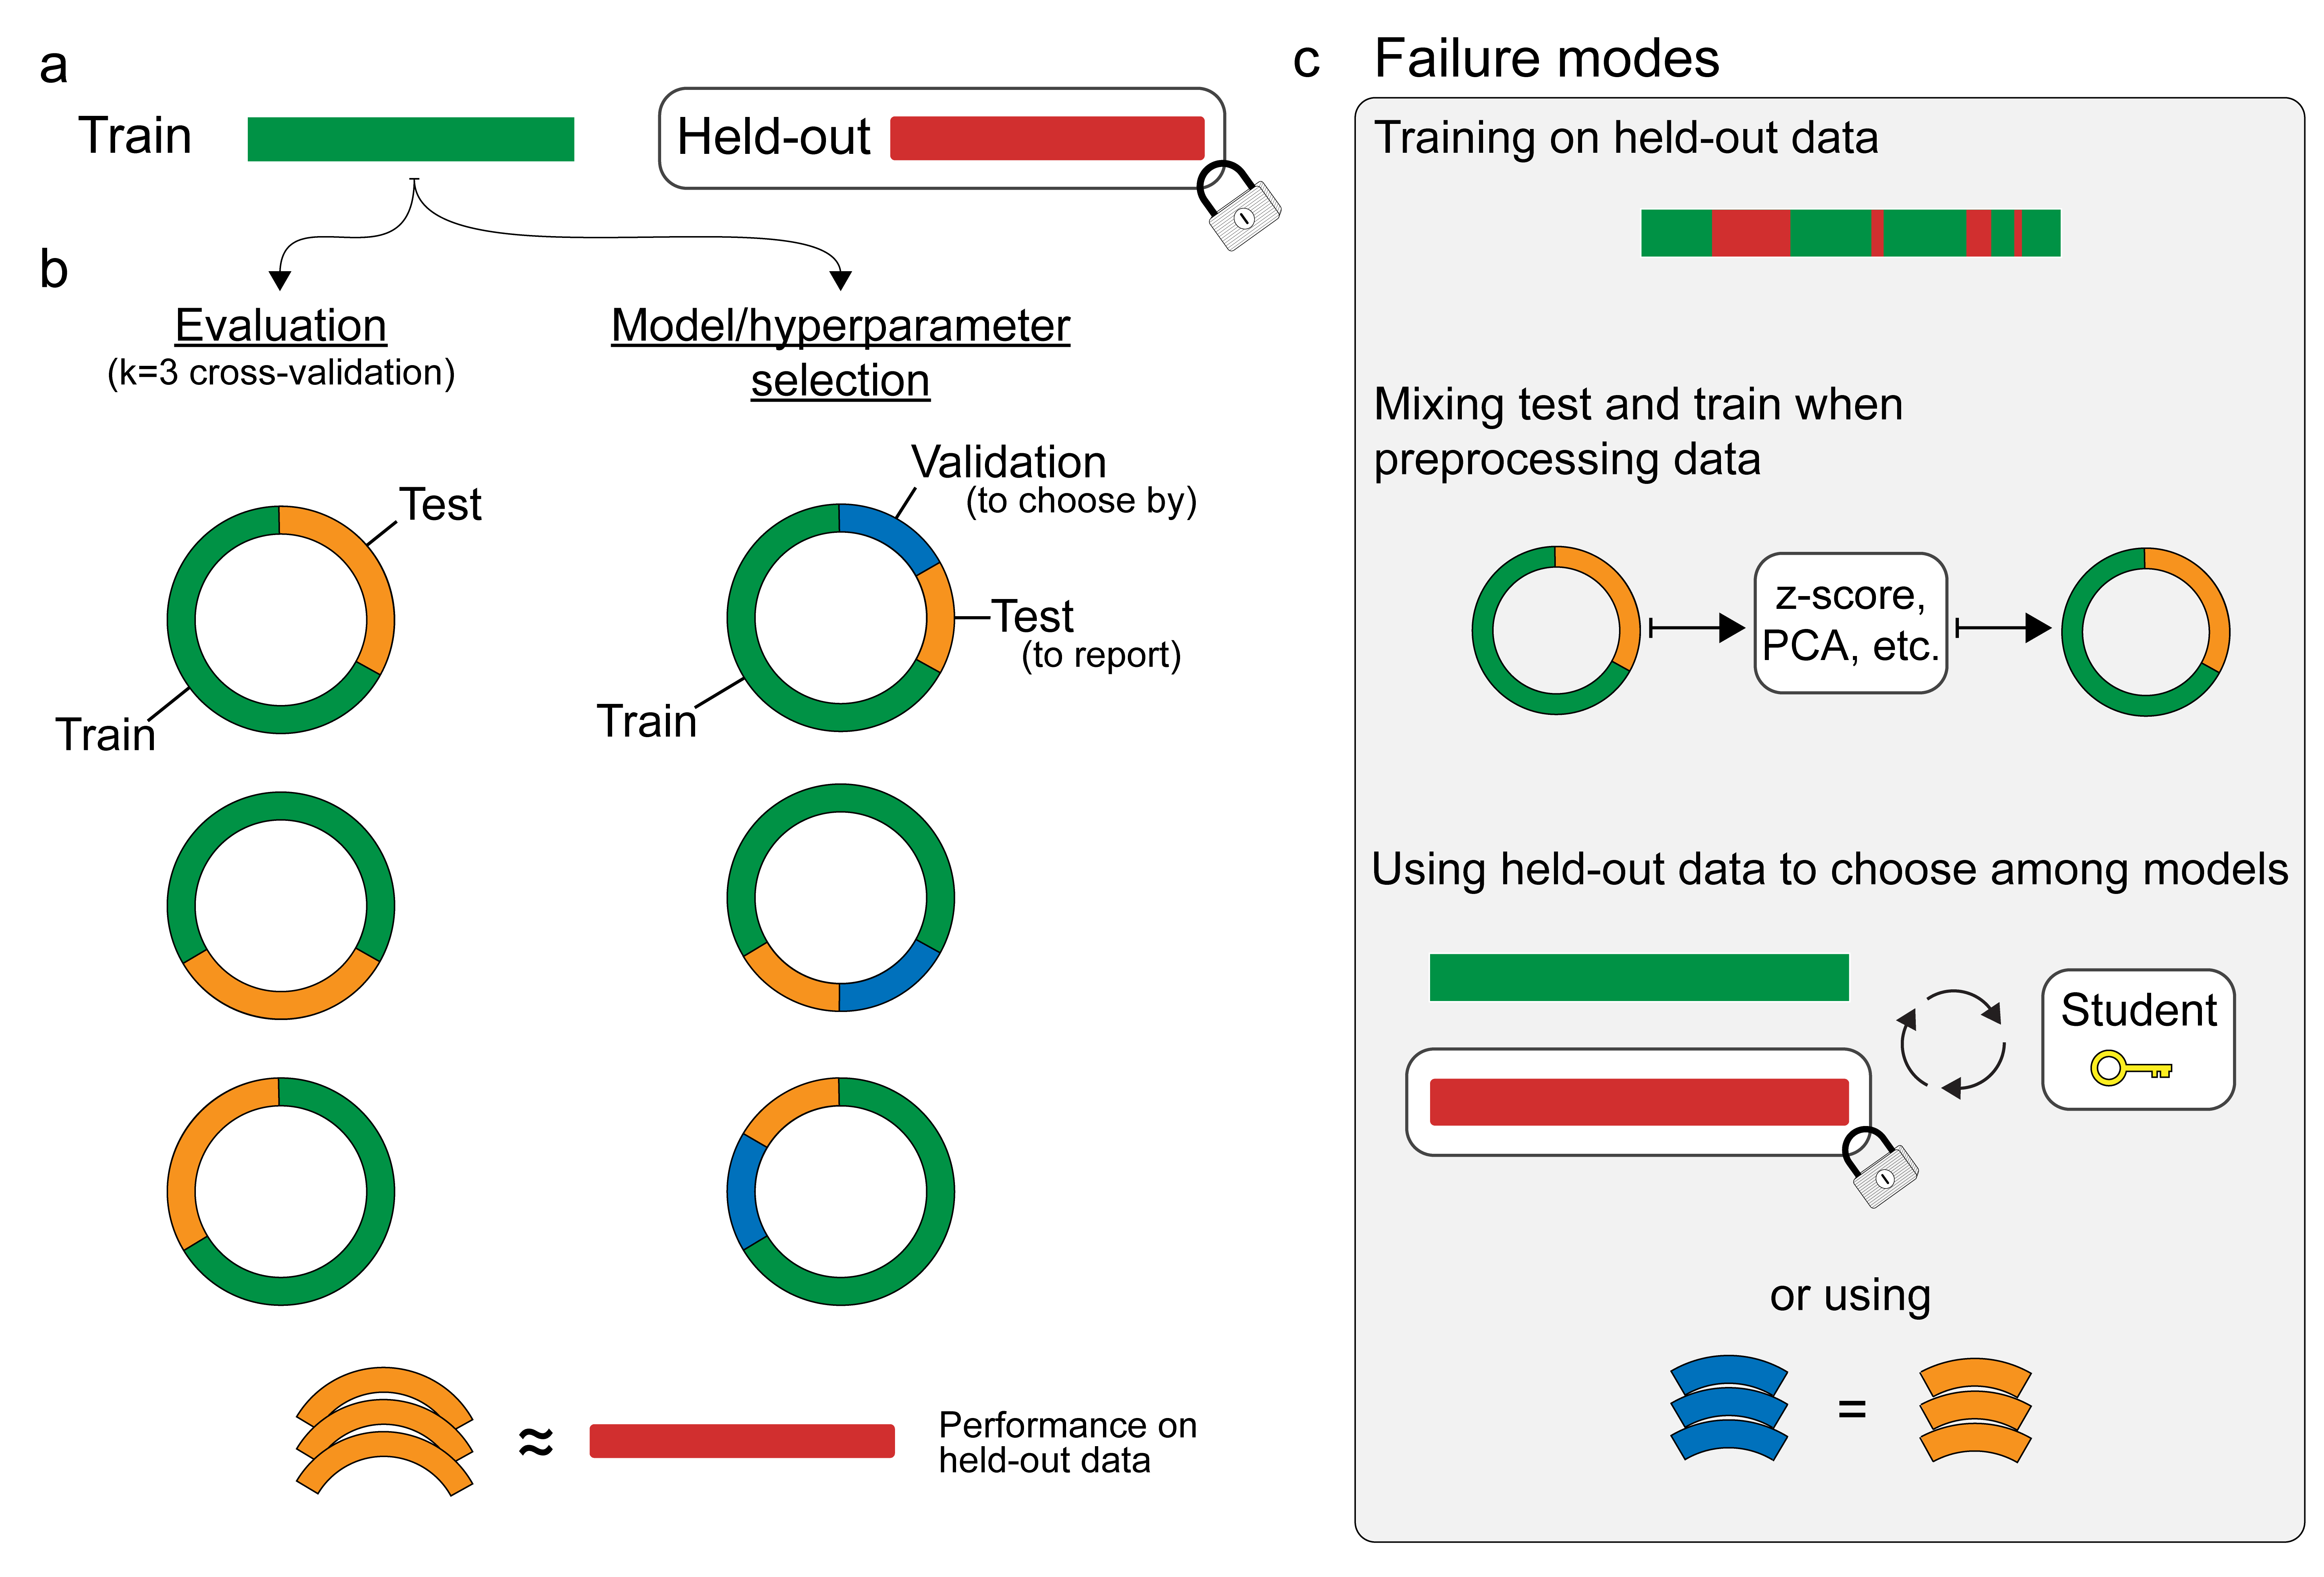

In [1]:
# @markdown Execute to see schematic
import IPython
IPython.display.Image("http://kordinglab.com/images/others/CV-01.png")